In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
import datetime
from sklearn.metrics import r2_score
from sklearn.metrics.pairwise import cosine_similarity
import numpy as np
from matplotlib import pyplot as plt
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader, random_split
from tqdm import tqdm
import seaborn as sns
from time import perf_counter
import xgboost as xgb
from joblib import Parallel, delayed
from numpy import linalg as LA
import pandas as pd

from tst import Transformer, Transformer_with_sst
import os
import pandas as pd
import torch.nn as nn
from torch.utils.data import Dataset, DataLoader

In [3]:
plt.rcParams.update({'font.size': 13})

Download only sst data (365 days per year)

In [4]:
sst_400_train = np.load('sst_train_400pc_new_smooth.npy')
sst_400_test = np.load('sst_test_400pc_new_smooth.npy')

In [40]:
# compressed_sst_train = np.load('sst_train_400pc_new_smooth.npy')
# compressed_sst_test = np.load('sst_test_400pc_new_smooth.npy')

In [5]:
sst_all_years = np.concatenate((sst_400_train, sst_400_test), axis=0)

In [6]:
sst_all_years.shape

(12396, 400)

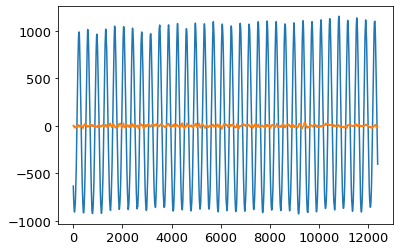

In [7]:
plt.plot(sst_all_years[:,0])
plt.plot(sst_all_years[:,100])

In [1]:
# path = '/share/data/willett-group/'


# us_mask = pd.DataFrame(pd.read_hdf(path + 'us_mask.h5'))
# # This block is to put all nearby sst data together in time order
# # And also transform data into time order (single location\)
# y_samp = pd.Series()
# X_total = []

# # target location
# tar_lat = 33.75
# tar_lon = 242.25
# start = 1985 #2014

# sst_all_years = np.zeros((365, 169727))

# for i in range(start, 2019): #(2014,2019):
#     print('precip.'+str(i)+'.h5')
# #     name_precip = 'precip.'+str(i)+'.h5'
#     name_sst = 'sst.'+str(i)+'.h5' 
#     fileloc_sst = path + name_sst

#     sst = pd.DataFrame(pd.read_hdf(fileloc_sst)).reset_index() # Daily sea surface temperature
#     sst.columns = ['lat', 'lon', 'start_date', 'sst']

    
#     if i%4 == 0:
#         days = 366
#     else:
#         days = 365
#     temp = sst #sst[(sst['lat']>=24.25) & (sst['lat']<=26.25) & (sst['lon']>=278.25) & (sst['lon']<=280.25)]
#     print(temp.shape)
#     sst_samp = temp.sst.reset_index().sst.to_numpy()
#     print(sst_samp.shape)
#     size = int(len(sst_samp)/days)
#     sst_samp = np.reshape(sst_samp,(size, days)).transpose()[:365] # days as rows, different locations as columns
#     print(sst_samp.shape)
#     if i == start:
#         sst_all_years = sst_samp
#     else:
#         sst_all_years = np.concatenate((sst_all_years, sst_samp), axis=0)
    

In [ ]:
# sst_samp.shape

In [8]:
sst_all_years.shape

(12396, 400)

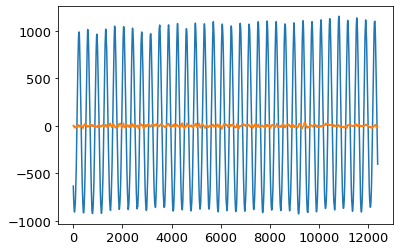

In [9]:
plt.plot(sst_all_years[:,0])
plt.plot(sst_all_years[:,100])

In [10]:
# avg_window = 14
# sst_movavg = []
# for i in range(sst_all_years.shape[0]-avg_window):
#     y_avg = np.mean(sst_all_years[i:i+avg_window], axis=0)
#     sst_movavg.append(y_avg)
# sst_movavg = np.array(sst_movavg)
# sst_all_years = sst_movavg

In [11]:
a = np.array([[1,2,3], 
              [4,5,6]])
a.shape, a.ravel().shape

((2, 3), (6,))

In [12]:
sst_all_years.shape

(12396, 400)

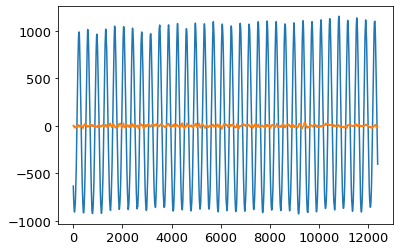

In [13]:
plt.plot(sst_all_years[:,0])
plt.plot(sst_all_years[:,100])

In [10]:
train_test_split = 0.8
test_size = int((1-train_test_split)*sst_all_years.shape[0])
X_train = sst_all_years[:-test_size]
X_test = sst_all_years[-test_size:]

In [11]:
X_train.shape, X_test.shape

((9917, 400), (2479, 400))

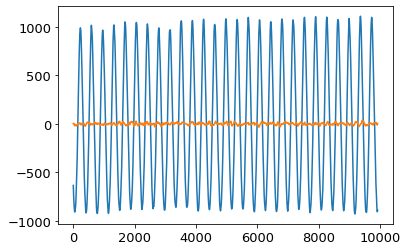

In [12]:
plt.plot(X_train[:,0])
plt.plot(X_train[:,100])

In [17]:
# from sklearn.decomposition import PCA

# n = 400

# pca = PCA(n)
# sst_data_train_pca = pca.fit_transform(X_train)
# sst_data_test_pca = pca.transform(X_test)

In [18]:
# sst_data_train_pca.shape, sst_data_test_pca.shape

In [19]:
# np.save('sst_train_400pc_new_smooth.npy', sst_data_train_pca)
# np.save('sst_test_400pc_new_smooth.npy', sst_data_test_pca)

In [13]:
M = np.max(X_train)
m = np.min(X_train)
X_train = (X_train -m)/(M - m)

X_test = (X_test -m)/(M - m)

In [14]:
print(X_train.min(), X_train.max())

0.0 1.0


In [15]:
train_data = torch.FloatTensor(X_train)

In [16]:
train_data.shape

torch.Size([9917, 400])

In [17]:
import os
os.environ['CUDA_VISIBLE_DEVICES'] = '0'
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
# train_data = train_data.to(device)

In [25]:
class SimpleDataset(Dataset):
    def __init__(self, data):
        self.samples = data

    def __len__(self):
        return len(self.samples)

    def __getitem__(self, idx):
        return self.samples[idx]

In [26]:
BATCH_SIZE = 128
dataset_train = SimpleDataset(X_train)
dataloader_train = DataLoader(dataset_train,
                              batch_size=BATCH_SIZE,
                              shuffle=False,
                              num_workers=0,
                              pin_memory=False
                             )

In [27]:
for x in dataloader_train:
    break

In [28]:
x.shape

torch.Size([128, 400])

### AE part

In [29]:
class AE(nn.Module):
    def __init__(self, in_shape, hid_dim):
        super(AE, self).__init__()
        
        self.encoder = nn.Sequential(
            nn.Linear(in_shape, 200),
            nn.ReLU(True),
            nn.Dropout(0.3),
            nn.Linear(200, 100),
            nn.ReLU(True),
            nn.Dropout(0.2),
            nn.Linear(100, hid_dim),)
        
        self.decoder = nn.Sequential(             
            nn.Linear(hid_dim, 100),
            nn.ReLU(True),
            nn.Dropout(0.3),
            nn.Linear(100, 200),
            nn.ReLU(True),
            nn.Dropout(0.2),
            nn.Linear(200, in_shape),
            nn.Sigmoid(),)
        
    def forward(self, x):
        x = self.encoder(x)
        x = self.decoder(x)
        return x

In [30]:
hid_dim = 100

model = AE(400, hid_dim).to(device)
distance = nn.MSELoss()
optimizer = torch.optim.Adam(model.parameters(), lr=1e-3) #weight_decay=1e-5)

In [32]:
num_epochs = 20
losses = []
for epoch in range(num_epochs):
    running_loss = 0
    for data in dataloader_train:
        data = data.to(device)
        
        output = model(data)
        loss = distance(output, data)
        running_loss += loss.item()
        
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        
    train_loss = running_loss/len(dataloader_train)
    losses.append(train_loss)
    print('epoch [{}/{}], loss:{:.4f}'.format(epoch+1, num_epochs, train_loss))

epoch [1/20], loss:0.0006
epoch [2/20], loss:0.0004
epoch [3/20], loss:0.0004
epoch [4/20], loss:0.0004
epoch [5/20], loss:0.0003
epoch [6/20], loss:0.0002
epoch [7/20], loss:0.0002
epoch [8/20], loss:0.0002
epoch [9/20], loss:0.0002
epoch [10/20], loss:0.0002
epoch [11/20], loss:0.0002
epoch [12/20], loss:0.0002
epoch [13/20], loss:0.0002
epoch [14/20], loss:0.0002
epoch [15/20], loss:0.0002
epoch [16/20], loss:0.0002
epoch [17/20], loss:0.0002
epoch [18/20], loss:0.0002
epoch [19/20], loss:0.0002
epoch [20/20], loss:0.0002


In [33]:
dataset_test = SimpleDataset(X_test)
dataloader_test = DataLoader(dataset_test,
                              batch_size=BATCH_SIZE,
                              shuffle=False,
                              num_workers=0,
                              pin_memory=False
                             )

In [34]:
model.eval()
running_loss = 0
with torch.no_grad():
    running_loss = 0
    for data in dataloader_test:
        data = data.to(device)
        
        output = model(data)
        
        loss = distance(output, data)
        running_loss += loss.item()
        
    test_loss = running_loss/len(dataloader_test)

In [35]:
test_loss

9.954767119779717e-05

In [36]:
data[10].shape

torch.Size([400])

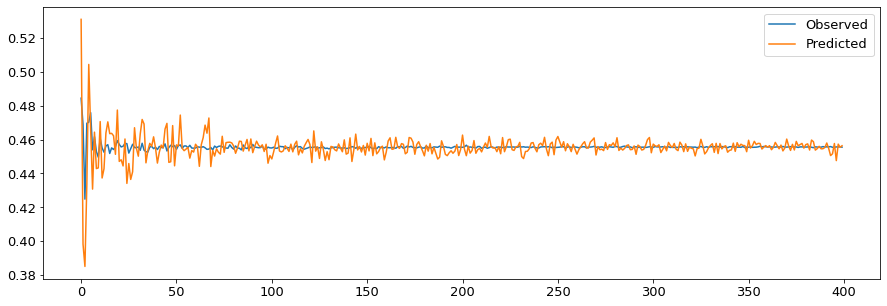

In [37]:
out = model(data[10]).cpu()

plt.figure(figsize=(15,5))
plt.plot(out.detach().numpy(),label='Observed')
plt.plot(data[10].cpu(), label='Predicted')
plt.legend();

In [38]:
model.encoder((data)).shape

torch.Size([47, 100])

In [39]:
# compressed_sst_train = model(torch.FloatTensor(X_train).to(device)).cpu()
# compressed_sst_test = model(torch.FloatTensor(X_test).to(device)).cpu()

In [40]:
compressed_sst_train = X_train
compressed_sst_test = X_test

Compress our test and train data.

In [41]:
# BATCH_SIZE = 64
# hid_dim = 10

In [42]:
compressed_sst_train = np.zeros((BATCH_SIZE, hid_dim))
compressed_sst_test = np.zeros((BATCH_SIZE, hid_dim))
model.eval()

c = 0
for data in dataloader_train:
    data = data.to(device)

    output = model.encoder((data))
    if c ==0:
        compressed_sst_train = output.data.cpu().numpy()
    else:
        compressed_sst_train = np.concatenate((compressed_sst_train, output.data.cpu().numpy()), axis=0)
    c += 1
    
c = 0    
for data in dataloader_test:
        data = data.to(device)
        
        output = model.encoder((data))
        if c ==0:
            compressed_sst_test = output.data.cpu().numpy()
        else:
            compressed_sst_test = np.concatenate((compressed_sst_test, output.data.cpu().numpy()), axis=0)
        c += 1

In [19]:
compressed_sst_train.shape, compressed_sst_test.shape

((9917, 400), (2479, 400))

In [18]:
# compressed_sst_train = X_train.copy()
# compressed_sst_test = X_test.copy()

In [44]:
# np.save('data/sst_tr_ae_100.npy', compressed_sst_train)
# np.save('data/sst_te_ae_100.npy', compressed_sst_test)

In [45]:
# compressed_sst_train = np.load('data/sst_tr_ae_10.npy')
# compressed_sst_test = np.load('data/sst_te_ae_10.npy')

#### Compressed sst and other features to Transformer/Boosting

X_samp -- (len, 3) where 3 - hgt, rhum, precip. y_samp - only tmp2 data.

In [20]:
X_samp = np.load('/share/data/willett-group/X_samp_wholetime_3features.npy')
y_samp = np.load('/share/data/willett-group/y_samp_wholetime_3features.npy')

Download whole data (without sst) -- or skip this line and download data from .npy files on shared folder.

In [36]:
path = '/share/data/willett-group/'


us_mask = pd.DataFrame(pd.read_hdf(path + 'us_mask.h5'))
# This block is to put all nearby sst data together in time order
# And also transform data into time order (single location\)
y_samp = pd.Series()
X_total = []

# target location
tar_lat = 33.75
tar_lon = 242.25

for i in range(1985,2019): #(2014,2019):
    print('precip.'+str(i)+'.h5')
    name_precip = 'precip.'+str(i)+'.h5'
    name_sst = 'sst.'+str(i)+'.h5' 
    name_hgt = 'hgt500.'+str(i)+'.h5'
    name_rhum = 'rhum.sig995.'+str(i)+'.h5'
    name_tmp2m = 'tmp2m.'+str(i)+'.h5'
    fileloc_precip = path + name_precip
    fileloc_sst = path + name_sst
    fileloc_hgt = path + name_hgt
    fileloc_rhum = path + name_rhum
    fileloc_tmp2m = path + name_tmp2m
    precip = pd.DataFrame(pd.read_hdf(fileloc_precip)).reset_index() # precipitation
    precip.columns = ['lat', 'lon', 'start_date', 'precip']
#     sst = pd.DataFrame(pd.read_hdf(fileloc_sst)).reset_index() # Daily sea surface temperature
#     sst.columns = ['lat', 'lon', 'start_date', 'sst']
    hgt = pd.DataFrame(pd.read_hdf(fileloc_hgt)).reset_index() # Daily geopotential height at 10mb and 500mb
    hgt.columns = ['lat', 'lon', 'start_date', 'hgt']
    rhum = pd.DataFrame(pd.read_hdf(fileloc_rhum)).reset_index() # Daily relative humidity near the surface
    rhum.columns = ['lat', 'lon', 'start_date', 'rhum']
    tmp2m = pd.DataFrame(pd.read_hdf(fileloc_tmp2m)).reset_index() # Daily average temperature at 2 meters
    tmp2m.columns = ['lat', 'lon', 'start_date', 'tmp2m']
#     print('original', tmp2m.shape)
    
    precip = pd.merge(precip, us_mask, on=['lat','lon'])
    hgt = pd.merge(hgt, us_mask, on=['lat','lon'])
    rhum = pd.merge(rhum, us_mask, on=['lat','lon'])
    tmp2m = pd.merge(tmp2m, us_mask, on=['lat','lon'])
#     print('after merge', tmp2m.shape)
    
#     hgt = np.reshape(hgt[(hgt['lat']==25.25) & (hgt['lon']==279.25)].hgt.to_numpy(),(-1,1))
#     rhum = np.reshape(rhum[(rhum['lat']==25.25) & (rhum['lon']==279.25)].rhum.to_numpy(),(-1,1))
#     tmp2m = np.reshape(tmp2m[(tmp2m['lat']==25.25) & (tmp2m['lon']==279.25)].tmp2m.to_numpy(),(-1,1))
    hgt = np.reshape(hgt[(hgt['lat']==tar_lat) & (hgt['lon']==tar_lon)].hgt.to_numpy(),(-1,1))
    hgt = hgt[:365]
    rhum = np.reshape(rhum[(rhum['lat']==tar_lat) & (rhum['lon']==tar_lon)].rhum.to_numpy(),(-1,1))
    rhum = rhum[:365]
    precip = np.reshape(precip[(precip['lat']==tar_lat) & (precip['lon']==tar_lon)].precip.to_numpy(),(-1,1))
    precip = precip[:365]
    
    y_samp = y_samp.append(tmp2m[(tmp2m['lat']==tar_lat) & (tmp2m['lon']==tar_lon)].tmp2m[:365],ignore_index=True)
    
    tmp2m = np.reshape(tmp2m[(tmp2m['lat']==tar_lat) & (tmp2m['lon']==tar_lon)].tmp2m.to_numpy(),(-1,1))
    tmp2m = tmp2m[:365]
    
#     y_samp.append(tmp2m)
    #y_samp = y_samp.append(precip[(precip['lat']==tar_lat) & (precip['lon']==tar_lon)].precip,ignore_index=True)
    print('one location', tmp2m.shape)
    
#     y_samp = y_samp.append(precip[precip['lat']==25.25].precip,ignore_index=True)
    
    if i%4 == 0:
        days = 366
    else:
        days = 365
#     temp = sst #sst[(sst['lat']>=24.25) & (sst['lat']<=26.25) & (sst['lon']>=278.25) & (sst['lon']<=280.25)]
#     print(temp.shape)
#     sst_samp = temp.sst.reset_index().sst.to_numpy()
#     print(sst_samp.shape)
#     size = int(len(sst_samp)/days)
#     sst_samp = np.reshape(sst_samp,(size, days)).transpose() # days as rows, different locations as columns
#     if sst_samp.shape[0] == tmp2m.shape[0]:
#         all_features = np.concatenate((sst_samp,hgt,rhum,tmp2m),axis=1)
#     else:
#         sst_samp = sst_samp[:365]
#         hgt = hgt[:365]
#         rhum = rhum[:365]
#     sst_samp = sst_samp[:365]
    tmp2m = tmp2m[:365]
    hgt = hgt[:365]
    rhum = rhum[:365]
    all_features = np.concatenate((hgt, rhum, precip),axis=1)
    print('all_features', all_features.shape)
    X_total.append(all_features)
    
X_size = X_total[0].shape[1]
X_samp = np.zeros((1, X_size)) #  For concatenating all data
print(X_samp.shape)
for i in range(len(X_total)):
    X_samp = np.concatenate((X_samp, X_total[i]), axis = 0)
X_samp = X_samp[1:]
print(X_samp.shape)

<ipython-input-36-4768dff50e72>:7: DeprecationWarning: The default dtype for empty Series will be 'object' instead of 'float64' in a future version. Specify a dtype explicitly to silence this warning.
  y_samp = pd.Series()


precip.1985.h5
one location (365, 1)
all_features (365, 3)
precip.1986.h5
one location (365, 1)
all_features (365, 3)
precip.1987.h5
one location (365, 1)
all_features (365, 3)
precip.1988.h5
one location (365, 1)
all_features (365, 3)
precip.1989.h5
one location (365, 1)
all_features (365, 3)
precip.1990.h5
one location (365, 1)
all_features (365, 3)
precip.1991.h5
one location (365, 1)
all_features (365, 3)
precip.1992.h5
one location (365, 1)
all_features (365, 3)
precip.1993.h5
one location (365, 1)
all_features (365, 3)
precip.1994.h5
one location (365, 1)
all_features (365, 3)
precip.1995.h5
one location (365, 1)
all_features (365, 3)
precip.1996.h5
one location (365, 1)
all_features (365, 3)
precip.1997.h5
one location (365, 1)
all_features (365, 3)
precip.1998.h5
one location (365, 1)
all_features (365, 3)
precip.1999.h5
one location (365, 1)
all_features (365, 3)
precip.2000.h5
one location (365, 1)
all_features (365, 3)
precip.2001.h5
one location (365, 1)
all_features (365, 

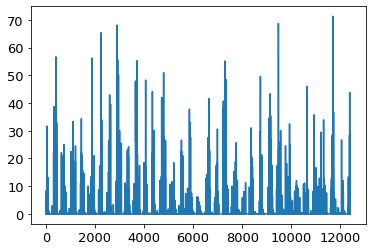

In [80]:
plt.plot(X_samp[:, 2])

Swap tmp and precip in a such way that X_samp is hgt, rhum, tmp and y_samp is precip.

In [21]:
precip = X_samp[:, 2].copy()
precip = np.log10(precip + 1.0)
X_samp[:, 2] = y_samp.copy()
y_samp = precip.copy()

In [22]:
X_copy = X_samp.copy()
y_copy = y_samp.copy()
target = 'precip'

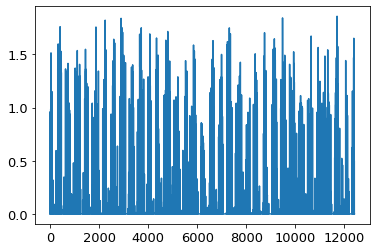

In [23]:
plt.plot(precip)

In [24]:
X_samp.shape, y_samp.shape

((12410, 3), (12410,))

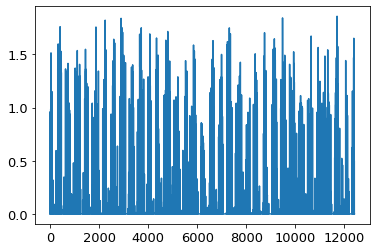

In [25]:
plt.plot(y_samp);

In [26]:
avg_window = 14
y_movavg = []
X_movavg = []
for i in range(y_samp.shape[0]-avg_window):
    y_avg = np.mean(y_samp[i:i+avg_window])
    y_movavg.append(y_avg)
    X_avg = np.mean(X_samp[i:i+avg_window],axis=0)
    X_movavg.append(X_avg)
y_movavg = np.array(y_movavg)
X_movavg = np.array(X_movavg)
y_samp = y_movavg
X_samp = X_movavg

In [27]:
X_samp.shape, y_samp.shape

((12396, 3), (12396,))

In [28]:
X = X_samp.copy()
y = y_samp.copy()

In [29]:
train_test_split = 0.8
test_size = int((1-train_test_split)*y_samp.shape[0])
X_train = X[:-test_size]
X_test = X[-test_size:]
y_train = y[:-test_size]
y_test = y[-test_size:]

In [30]:
y_train = np.reshape(y_train,(-1,1))  #  Matching dimension for concatenating X and y
y_test = np.reshape(y_test,(-1,1)) 

In [31]:
X_train.shape, X_test.shape

((9917, 3), (2479, 3))

In [32]:
M = np.max(y_train)
m = np.min(y_train)
y_train = (y_train -m)/(M - m)

X_train_max_0 = np.max(X_train[:,0])
X_train_min_0 = np.min(X_train[:,0])
X_train[:,0] = (X_train[:,0] - np.min(X_train[:,0]))/ (np.max(X_train[:,0]) - np.min(X_train[:,0]))

X_train_max_1 = np.max(X_train[:,1])
X_train_min_1 = np.min(X_train[:,1])
X_train[:,1] = (X_train[:,1] - np.min(X_train[:,1]))/(np.max(X_train[:,1]) - np.min(X_train[:,1]))

X_train_max_2 = np.max(X_train[:,2])
X_train_min_2 = np.min(X_train[:,2])
X_train[:,2] = (X_train[:,2] - np.min(X_train[:,2]))/(np.max(X_train[:,2]) - np.min(X_train[:,2]))

In [33]:
y_test = (y_test -m)/(M - m)
X_test[:,0] = (X_test[:,0] - X_train_min_0)/ (X_train_max_0 - X_train_min_0)
X_test[:,1] = (X_test[:,1] - X_train_min_1)/(X_train_max_1 - X_train_min_1)
X_test[:,2] = (X_test[:,2] - X_train_min_2)/ (X_train_max_2 - X_train_min_2)

In [34]:
print(y_train.max(), y_train.min())
print(X_train.max(), X_train.min())
print(y_test.max(), y_test.min())
print(X_test.max(), X_test.min())

1.0 0.0
1.0 0.0
0.5832014392661486 0.0
1.0197713628210308 -0.02969096557274323


In [35]:
X_train.shape, X_test.shape, y_train.shape, y_test.shape

((9917, 3), (2479, 3), (9917, 1), (2479, 1))

Concatenate data from AE and land features.

In [36]:
compressed_sst_train.shape

(9917, 400)

In [37]:
train_data_array = np.concatenate((compressed_sst_train, X_train, y_train), axis=1)
test_data_array = np.concatenate((compressed_sst_test, X_test, y_test), axis=1)

In [38]:
train_data_array.shape, test_data_array.shape

((9917, 404), (2479, 404))

In [40]:
train_data = torch.FloatTensor(train_data_array)
y_train = torch.FloatTensor(y_train)

In [39]:
import os
os.environ['CUDA_VISIBLE_DEVICES'] = '0'
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
# train_data = train_data.to(device)
# y_train = y_train.to(device)

In [43]:
def create_sequence(input_data, train_window, pred_window):  #  Create sequences of observations for training
    seq = []
    L = len(input_data)
    feature_size = input_data[0].shape[0]
    print('feature_size', feature_size)
    for i in range(L - train_window-pred_window):
        train_seq = input_data[i:i+train_window]
        train_label = input_data[i+train_window+pred_window-1,feature_size-1] # get y_t+14
#         train_label = input_data[i + train_window + pred_window]
        seq.append((train_seq ,train_label))
        
    print('train_seq, train_label', train_seq.shape, train_label.shape)
    return seq

In [44]:
train_window = 90
pred_window = 28
train_seq = create_sequence(train_data, train_window, pred_window)

feature_size 404
train_seq, train_label torch.Size([90, 404]) torch.Size([])


### for XGBoost

In [45]:
def create_sequence_with_reshape(input_data, train_window, pred_window):  #  Create sequences of observations for training
    seq_x = []
    seq_y = []
    L = len(input_data)
    feature_size = input_data[0].shape[0]
    print('feature_size', feature_size)
    for i in range(L - train_window-pred_window):
        train_seq = input_data[i:i+train_window].ravel()
        train_label = input_data[i+train_window+pred_window-1,feature_size-1] # get y_t+14
#         train_label = input_data[i + train_window + pred_window]
        seq_x.append(train_seq)
        seq_y.append(train_label)
        
#     print('train_seq, train_label', seq_x.shape, seq_y.shape)
    return seq_x, seq_y

In [46]:
train_data_array.shape

(9917, 404)

In [47]:
train_window = 90
pred_window = 28
train_seq_x, train_seq_y = create_sequence_with_reshape(train_data_array, train_window, pred_window)

feature_size 404


In [48]:
a = [1, 2, 3, 4, 5]
a[:-2], a[-2:]

([1, 2, 3], [4, 5])

In [49]:
test_seq_x, test_seq_y = create_sequence_with_reshape(np.concatenate((train_data_array[-90-28:], test_data_array), 
                                                                     axis=0), train_window, pred_window)

feature_size 404


In [50]:
test_seq_x[0].shape

(36360,)

In [51]:
len(train_seq_y), len(test_seq_y)

(9799, 2479)

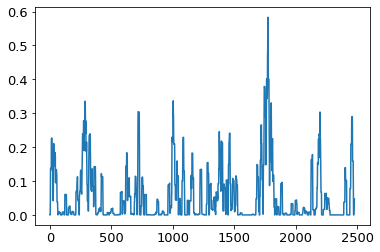

In [52]:
plt.plot(test_seq_y)

In [53]:
len(train_seq_x), train_seq_x[0].shape

(9799, (36360,))

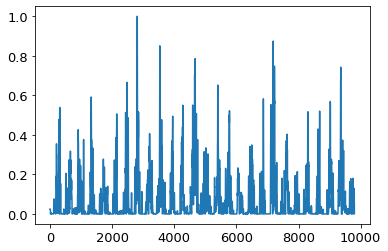

In [54]:
plt.plot(train_seq_y)

In [55]:
from torch.utils.data import Dataset, DataLoader

class SeqDataset(Dataset):
    def __init__(self, seq_data, transform=None):
        
        self.seq_data = seq_data
        self.x = []
        self.y = []
        for i in range(len(self.seq_data)):
            self.x.append(self.seq_data[i][0])
            self.y.append(self.seq_data[i][1])

    def __getitem__(self, idx):
        if torch.is_tensor(idx):
            idx = idx.tolist()

        return (self.x[idx], self.y[idx])

    def __len__(self):
        return len(train_seq) #self._x.shape[0]

In [56]:
dataset_train = SeqDataset(train_seq)
dataloader_train = DataLoader(dataset_train,
                              batch_size=128,
                              shuffle=False,
                              num_workers=0,
                              pin_memory=False
                             )

In [57]:
d_input = 404 # From dataset
d_output = 1 # From dataset

attention_size = 8
LR = 1e-5 #1e-3
d_model = 64
q = 8 # Query size
v = 8 # Value size
h = 4 # Number of heads
N = 4 # Number of encoder and decoder to stack
dropout = 0.2 # Dropout rate
# pe = 'original' # Positional encoding
chunk_mode = None
net = Transformer(d_input, d_model, d_output, q, v, h, N, attention_size=attention_size, 
                  dropout=dropout, chunk_mode=chunk_mode, pe='regular', pe_period=2, seq_length=90).to(device)
# net = nn.Sequential(Transformer(d_input, d_model, d_output, q, v, h, N, attention_size=attention_size, 
#                   dropout=dropout, chunk_mode=chunk_mode, pe=pe),
#                     nn.Flatten(),
#                     nn.Linear(30, 1),
#                    ).to(device)
optimizer = optim.Adam(net.parameters(), lr=LR)
loss_function = nn.MSELoss() #OZELoss(alpha=0.3)

In [58]:
# x.shape

[Epoch  96/150]: 100%|██████████| 9799/9799 [00:08<00:00, 1188.08it/s, loss=0.0112] 


[Epoch 150/150]: 100%|██████████| 9799/9799 [00:07<00:00, 1303.79it/s, loss=0.0108] 


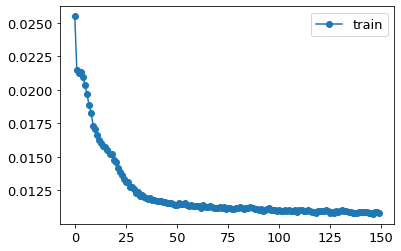

In [59]:
EPOCHS = 150
hist_loss = np.zeros(EPOCHS)
hist_loss_val = np.zeros(EPOCHS)

for idx_epoch in range(EPOCHS):
    running_loss = 0
    with tqdm(total=len(train_seq), desc=f"[Epoch {idx_epoch+1:3d}/{EPOCHS}]") as pbar:
        for idx_batch, (x, y_label) in enumerate(dataloader_train):
#             x = x.unsqueeze(0)
            y_label = y_label.view(-1,1)
            optimizer.zero_grad()

            # Propagate input
            netout = net(x.to(device))

            # Compute loss
#             print(netout, y)
            loss = loss_function(y_label.to(device), netout)

            # Backpropage loss
            loss.backward()

            # Update weights
            optimizer.step()

            running_loss += loss.item()
            pbar.set_postfix({'loss': running_loss/(idx_batch+1)})
            pbar.update(x.shape[0])
                
#         scheduler.step()    
        train_loss = running_loss/len(dataloader_train)
#         print('pred, target', netout, y)
#         val_loss = compute_loss(net, dataloader_val, loss_function, device).item()
#         pbar.set_postfix({'loss': train_loss, 'val_loss': val_loss})
        if idx_epoch % 10 ==0 or idx_epoch == EPOCHS-1:
            pbar.set_postfix({'loss': train_loss})

        hist_loss[idx_epoch] = train_loss
#         hist_loss_val[idx_epoch] = val_loss

#         if val_loss < val_loss_best:
#             val_loss_best = val_loss
#             torch.save(net.state_dict(), model_save_path)
        
plt.plot(hist_loss, 'o-', label='train')
# plt.plot(hist_loss_val, 'o-', label='val')
plt.legend()
# print(f"model exported to {model_save_path} with loss {val_loss_best:5f}")

In [61]:
# torch.save(net.to('cpu'), 'models/transform_dim50.pth') #0.80 r2 on test

In [60]:
train_data_array.shape, test_data_array.shape

((9917, 404), (2479, 404))

In [61]:
train_test_total = np.concatenate((train_data_array, test_data_array))

net.eval()
num_pred = 1 #  Number of prediction forward, i.e. tau
res = np.zeros(train_window).tolist()
#  Predicting y using X_test and y_test
for i in tqdm(range(train_test_total.shape[0]-train_window)):
    for j in range(num_pred):
        seq = torch.FloatTensor(train_test_total[i:i+train_window]).to(device)
        seq = seq.unsqueeze(0)
        #print(seq)
        with torch.no_grad():
            #print(model(seq))
            pred = net(seq).cpu()
            #print(len(test_inputs))
            res.append(pred)
            
res = np.array(res)

100%|██████████| 12306/12306 [03:35<00:00, 57.01it/s]


In [62]:
y_all = np.concatenate((y_train.cpu(), y_test))

r-sq on train: 0.3133126269733989
r-sq on test: 0.19385098693002611
cosine_similarity on train: [[0.71674836]]
cosine_similarity on test: [[0.71591869]]


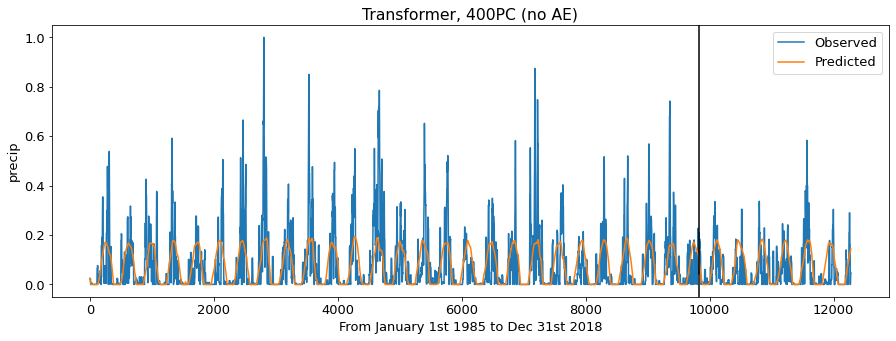

In [63]:
print('r-sq on train:', r2_score(y_all[train_window+pred_window:-test_size], res[train_window:-test_size-pred_window]))
print('r-sq on test:', r2_score(y_all[-test_size:],  res[-test_size-pred_window:-pred_window]))
print('cosine_similarity on train:', cosine_similarity(y_all[train_window+pred_window:-test_size].reshape((1,-1)), res[train_window:-test_size-pred_window].reshape((1,-1))))
print('cosine_similarity on test:', cosine_similarity(y_all[-test_size:].reshape((1,-1)),  res[-test_size-pred_window:-pred_window].reshape((1,-1))))
plt.figure(figsize=(15,5))
plt.plot(y_all[train_window+pred_window:],label='Observed')
plt.plot(res[train_window:-pred_window],label='Predicted')
plt.legend()
plt.xlabel('From January 1st 1985 to Dec 31st 2018')
plt.ylabel(target)
plt.title('Transformer, 400PC (no AE)')
plt.axvline(x=res.shape[0] - test_size-train_window,c='black');

r-sq on train: 0.34951602684316285
r-sq on test: 0.05660114379827608
cosine_similarity on train: [[0.73381708]]
cosine_similarity on test: [[0.70332316]]


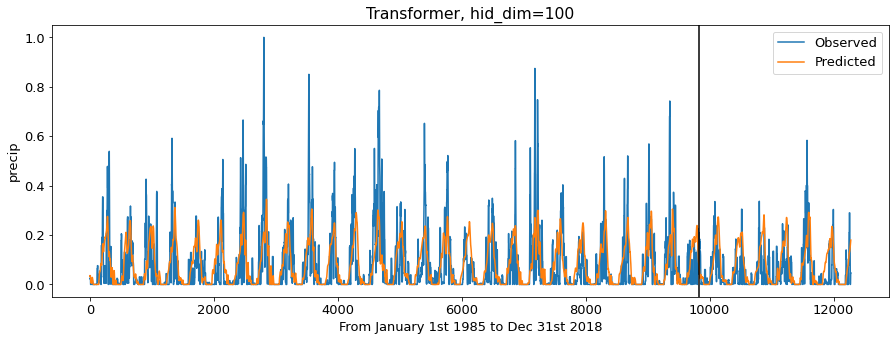

In [87]:
print('r-sq on train:', r2_score(y_all[train_window+pred_window:-test_size], res[train_window:-test_size-pred_window]))
print('r-sq on test:', r2_score(y_all[-test_size:],  res[-test_size-pred_window:-pred_window]))
print('cosine_similarity on train:', cosine_similarity(y_all[train_window+pred_window:-test_size].reshape((1,-1)), res[train_window:-test_size-pred_window].reshape((1,-1))))
print('cosine_similarity on test:', cosine_similarity(y_all[-test_size:].reshape((1,-1)),  res[-test_size-pred_window:-pred_window].reshape((1,-1))))
plt.figure(figsize=(15,5))
plt.plot(y_all[train_window+pred_window:],label='Observed')
plt.plot(res[train_window:-pred_window],label='Predicted')
plt.legend()
plt.xlabel('From January 1st 1985 to Dec 31st 2018')
plt.ylabel(target)
plt.title('Transformer, hid_dim=100')
plt.axvline(x=res.shape[0] - test_size-train_window,c='black');

r-sq on train: 0.2634510837323
r-sq on test: 0.04130142238206769
cosine_similarity on train: [[0.69022182]]
cosine_similarity on test: [[0.66071562]]


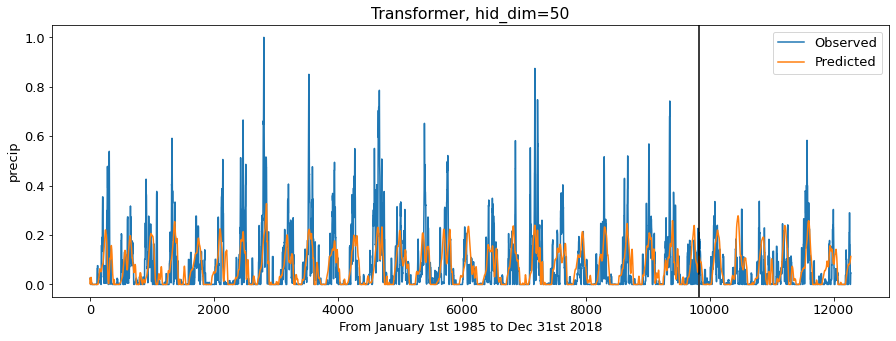

In [73]:
print('r-sq on train:', r2_score(y_all[train_window+pred_window:-test_size], res[train_window:-test_size-pred_window]))
print('r-sq on test:', r2_score(y_all[-test_size:],  res[-test_size-pred_window:-pred_window]))
print('cosine_similarity on train:', cosine_similarity(y_all[train_window+pred_window:-test_size].reshape((1,-1)), res[train_window:-test_size-pred_window].reshape((1,-1))))
print('cosine_similarity on test:', cosine_similarity(y_all[-test_size:].reshape((1,-1)),  res[-test_size-pred_window:-pred_window].reshape((1,-1))))
plt.figure(figsize=(15,5))
plt.plot(y_all[train_window+pred_window:],label='Observed')
plt.plot(res[train_window:-pred_window],label='Predicted')
plt.legend()
plt.xlabel('From January 1st 1985 to Dec 31st 2018')
plt.ylabel(target)
plt.title('Transformer, hid_dim=50')
plt.axvline(x=res.shape[0] - test_size-train_window,c='black');

r-sq on train: 0.38101592248939864
r-sq on test: 0.13648457614812348
cosine_similarity on train: [[0.75046691]]
cosine_similarity on test: [[0.6758509]]


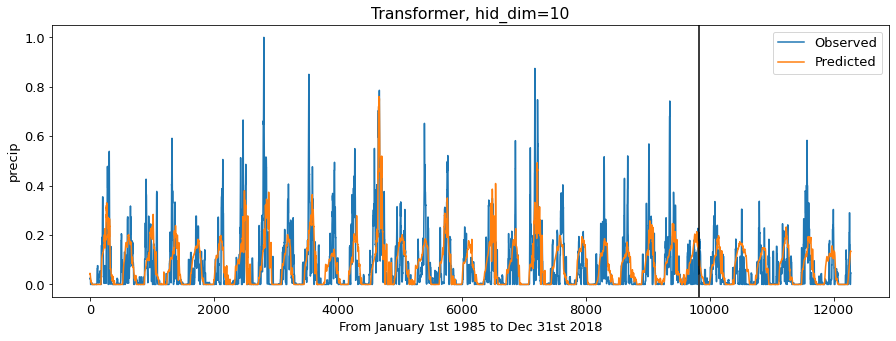

In [121]:
print('r-sq on train:', r2_score(y_all[train_window+pred_window:-test_size], res[train_window:-test_size-pred_window]))
print('r-sq on test:', r2_score(y_all[-test_size:],  res[-test_size-pred_window:-pred_window]))
print('cosine_similarity on train:', cosine_similarity(y_all[train_window+pred_window:-test_size].reshape((1,-1)), res[train_window:-test_size-pred_window].reshape((1,-1))))
print('cosine_similarity on test:', cosine_similarity(y_all[-test_size:].reshape((1,-1)),  res[-test_size-pred_window:-pred_window].reshape((1,-1))))
plt.figure(figsize=(15,5))
plt.plot(y_all[train_window+pred_window:],label='Observed')
plt.plot(res[train_window:-pred_window],label='Predicted')
plt.legend()
plt.xlabel('From January 1st 1985 to Dec 31st 2018')
plt.ylabel(target)
plt.title('Transformer, hid_dim=10')
plt.axvline(x=res.shape[0] - test_size-train_window,c='black');

In [153]:
y_test.shape

(2479, 1)

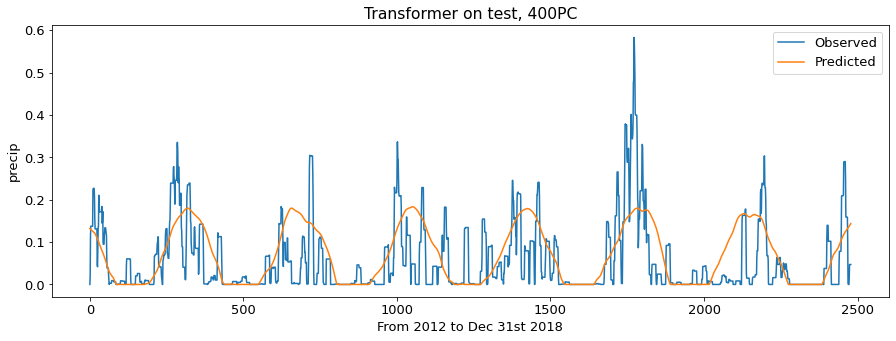

In [64]:
plt.figure(figsize=(15,5))
plt.plot(y_test,label='Observed')
plt.plot(res[-test_size-pred_window:-pred_window],label='Predicted')
plt.legend()
plt.xlabel('From 2012 to Dec 31st 2018')
plt.ylabel(target)
plt.title('Transformer on test, 400PC');

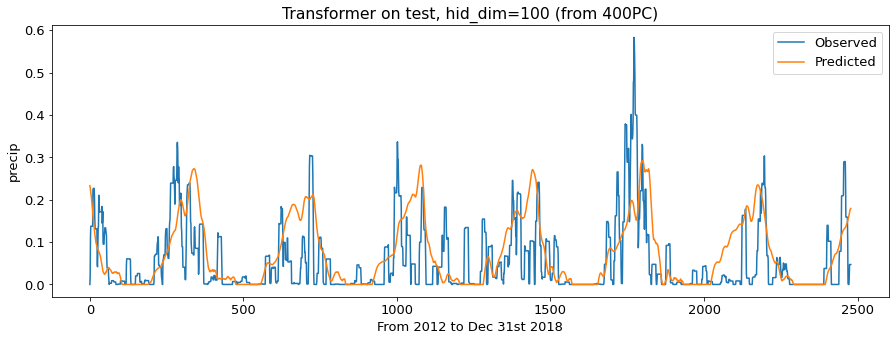

In [88]:
plt.figure(figsize=(15,5))
plt.plot(y_test,label='Observed')
plt.plot(res[-test_size-pred_window:-pred_window],label='Predicted')
plt.legend()
plt.xlabel('From 2012 to Dec 31st 2018')
plt.ylabel(target)
plt.title('Transformer on test, hid_dim=100 (from 400PC)');

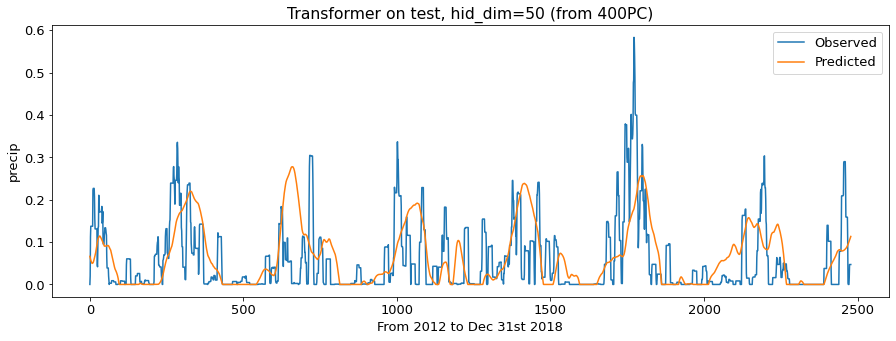

In [74]:
plt.figure(figsize=(15,5))
plt.plot(y_test,label='Observed')
plt.plot(res[-test_size-pred_window:-pred_window],label='Predicted')
plt.legend()
plt.xlabel('From 2012 to Dec 31st 2018')
plt.ylabel(target)
plt.title('Transformer on test, hid_dim=50 (from 400PC)');

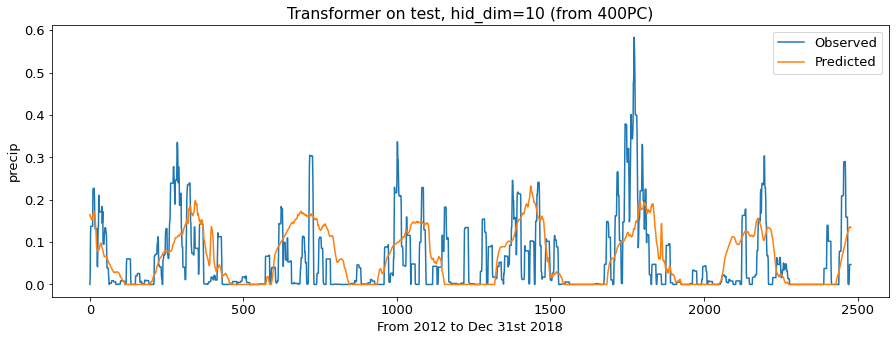

In [122]:
plt.figure(figsize=(15,5))
plt.plot(y_test,label='Observed')
plt.plot(res[-test_size-pred_window:-pred_window],label='Predicted')
plt.legend()
plt.xlabel('From 2012 to Dec 31st 2018')
plt.ylabel(target)
plt.title('Transformer on test, hid_dim=10 (from 400PC)');

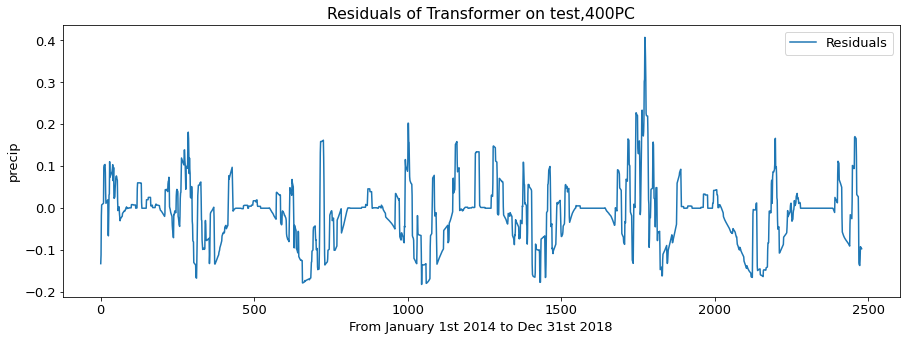

In [65]:
plt.figure(figsize=(15,5))
plt.plot(y_test.squeeze() - res[-test_size-pred_window:-pred_window],label='Residuals')
plt.legend()
plt.xlabel('From January 1st 2014 to Dec 31st 2018')
plt.ylabel(target)
plt.title('Residuals of Transformer on test,400PC');

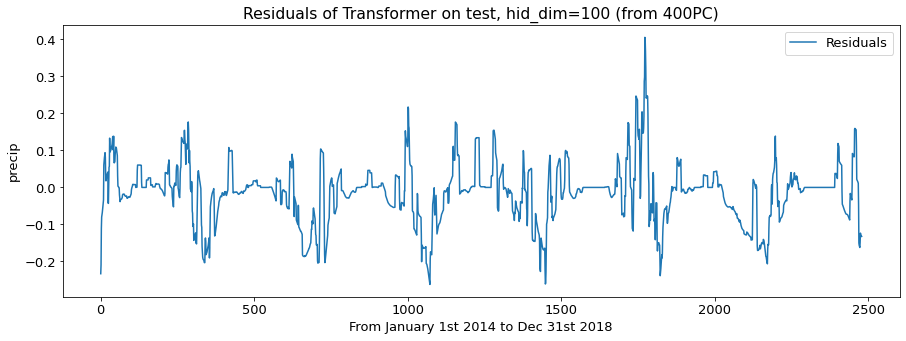

In [89]:
plt.figure(figsize=(15,5))
plt.plot(y_test.squeeze() - res[-test_size-pred_window:-pred_window],label='Residuals')
plt.legend()
plt.xlabel('From January 1st 2014 to Dec 31st 2018')
plt.ylabel(target)
plt.title('Residuals of Transformer on test, hid_dim=100 (from 400PC)');

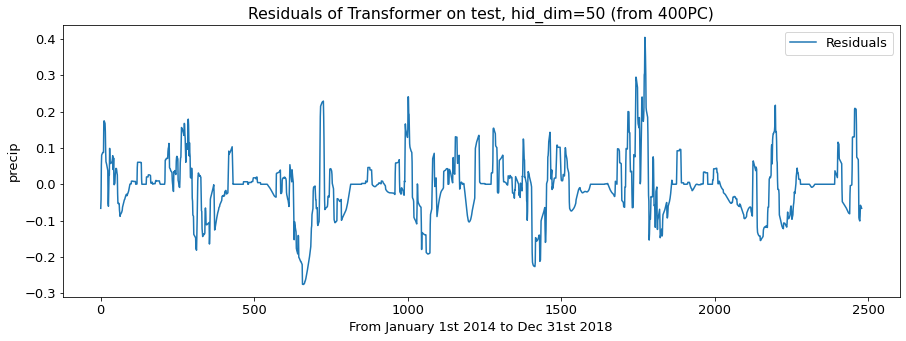

In [75]:
plt.figure(figsize=(15,5))
plt.plot(y_test.squeeze() - res[-test_size-pred_window:-pred_window],label='Residuals')
plt.legend()
plt.xlabel('From January 1st 2014 to Dec 31st 2018')
plt.ylabel(target)
plt.title('Residuals of Transformer on test, hid_dim=50 (from 400PC)');
# plt.axvline(x=X.shape[0]- test_size,c='black');

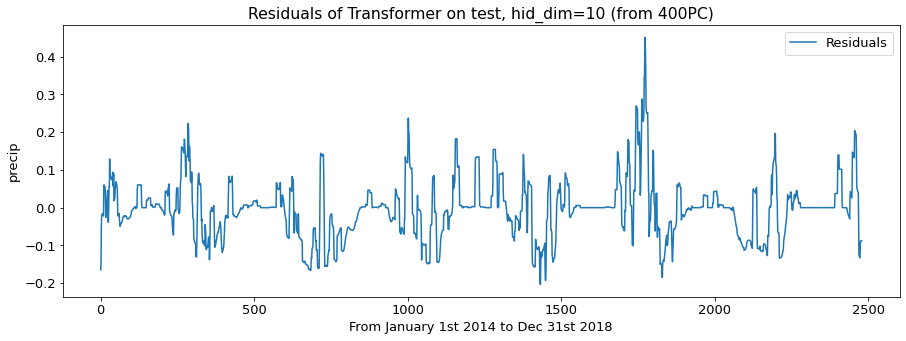

In [124]:
plt.figure(figsize=(15,5))
plt.plot(y_test.squeeze() - res[-test_size-pred_window:-pred_window],label='Residuals')
plt.legend()
plt.xlabel('From January 1st 2014 to Dec 31st 2018')
plt.ylabel(target)
plt.title('Residuals of Transformer on test, hid_dim=10 (from 400PC)');
# plt.axvline(x=X.shape[0]- test_size,c='black');

### XGBoost

In [66]:
class XGBoost():
    def __init__(self, num_models=3274, base_score=0.5, booster='gbtree', colsample_bylevel=1,
                 colsample_bytree=1, gamma=0, learning_rate=0.1, max_delta_step=0, max_depth=3,
                 min_child_weight=1, missing=None, n_estimators=100,
                 n_jobs=16, nthread=None, objective='reg:squarederror',
                 random_state=0, reg_alpha=0, reg_lambda=1,
                 scale_pos_weight=1, seed=None, silent=True, subsample=1):


        """ Initilize a list of XGBoost 
        """
        super().__init__()    

        self.models = [xgb.XGBRegressor(objective=objective, max_depth=max_depth, learning_rate=learning_rate,
                                        colsample_bytree=colsample_bytree, n_estimators=n_estimators, gamma=gamma,
                                        base_score=base_score, booster=booster, colsample_bylevel=colsample_bylevel,
                                        max_delta_step=max_delta_step, min_child_weight=min_child_weight, missing=missing,
                                        n_jobs=1, nthread=nthread, random_state=random_state,
                                        reg_alpha=reg_alpha, reg_lambda=reg_lambda,
                                        scale_pos_weight=scale_pos_weight, seed=seed,
                                        silent=silent, subsample=subsample, tree_method='gpu_hist', n_gpus=1) for i in range(num_models)]
        self.n_jobs = n_jobs
        self.num_models = num_models



    def fit(self, X, y):

        """ fit XGBoost model at each location
        """
#         self.models = Parallel(n_jobs=self.n_jobs)(delayed(self.models[loc].fit)(X, y[:, loc]) for loc in range(self.num_models))# 197x2x num_estimators
        self.models = Parallel(n_jobs=self.n_jobs)(delayed(self.models[loc].fit)(X, y) for loc in range(self.num_models))

        return self.models
  

    def fit_cv(self, train_x, train_y, val_x, val_y):

        """ For hyper-parameter tuning: fit XGBoost model at each location
        """
        history = np.asarray(Parallel(n_jobs=self.n_jobs)(delayed(self.fit_single_output)
                                                          (self.models[loc], train_x, train_y[:, loc], val_x, val_y[:, loc])
                                                          for loc in range(self.num_models)))# 197x2x num_estimators

        return history


    def predict(self, X):
        """ For XGBoost model at each location, make prediction
        """
        pred_y = np.asarray((Parallel(n_jobs=self.n_jobs)(delayed(self.models[loc].predict)(X) for loc in range(self.num_models))))# 197x2x num_estimators


        return pred_y.T


    def fit_single_output(self, mdl, train_x, train_y, test_x, test_y):
        """ For hyper-parameter tuning: fit XGBoost model at each location
        """
        eval_set = [(train_x, train_y), (test_x, test_y)]
        eval_metric = ['rmse']

        mdl.fit(train_x, train_y, eval_metric=eval_metric, eval_set=eval_set, verbose=True)


        train_eval = mdl.evals_result()['validation_0']['rmse']
        test_eval = mdl.evals_result()['validation_1']['rmse']


        return train_eval, test_eval

In [67]:
mdl = XGBoost(num_models=1, n_jobs=1)

In [68]:
len(train_seq_x), len(train_seq_y)

(9799, 9799)

In [69]:
train_seq_x = np.array(train_seq_x)
train_seq_y = np.array(train_seq_y)

test_seq_x = np.array(test_seq_x)
test_seq_y = np.array(test_seq_y)

In [70]:
mdl.fit(train_seq_x, train_seq_y)
# mdl.fit(train_data_array, y_train.numpy())

[10:41:34] WARNING: ../include/xgboost/generic_parameters.h:39: 
n_gpus: 
	Deprecated. Single process multi-GPU training is no longer supported.
	Please switch to distributed training with one process per GPU.
	This can be done using Dask or Spark.  See documentation for details.
[10:41:34] WARNING: ../src/learner.cc:541: 
Parameters: { silent } might not be used.

  This may not be accurate due to some parameters are only used in language bindings but
  passed down to XGBoost core.  Or some parameters are not used but slip through this
  verification. Please open an issue if you find above cases.


[10:41:45] WARNING: ../include/xgboost/generic_parameters.h:39: 
n_gpus: 
	Deprecated. Single process multi-GPU training is no longer supported.
	Please switch to distributed training with one process per GPU.
	This can be done using Dask or Spark.  See documentation for details.


[XGBRegressor(base_score=0.5, booster='gbtree', colsample_bylevel=1,
              colsample_bynode=1, colsample_bytree=1, gamma=0, gpu_id=0,
              importance_type='gain', interaction_constraints='',
              learning_rate=0.1, max_delta_step=0, max_depth=3,
              min_child_weight=1, missing=None, monotone_constraints='()',
              n_estimators=100, n_gpus=1, n_jobs=1, nthread=1,
              num_parallel_tree=1, random_state=0, reg_alpha=0, reg_lambda=1,
              scale_pos_weight=1, seed=0, silent=True, subsample=1,
              tree_method='gpu_hist', validate_parameters=1, verbosity=None)]

In [71]:
pred_train = mdl.predict(np.array(train_seq_x))
pred_test = mdl.predict(np.array(test_seq_x))

In [96]:
test_seq_y.shape, pred_test.shape

((2479,), (2479, 1))

In [97]:
a = [1, 2, 3, 4, 5]
a[3:]

[4, 5]

In [98]:
test_seq_y[train_window+pred_window:].shape

(2361,)

r-sq on train: 0.8933851252339902
r-sq on test: 0.16883615982754807
cosine_similarity on train: [[0.96594083]]
cosine_similarity on test: [[0.66241998]]


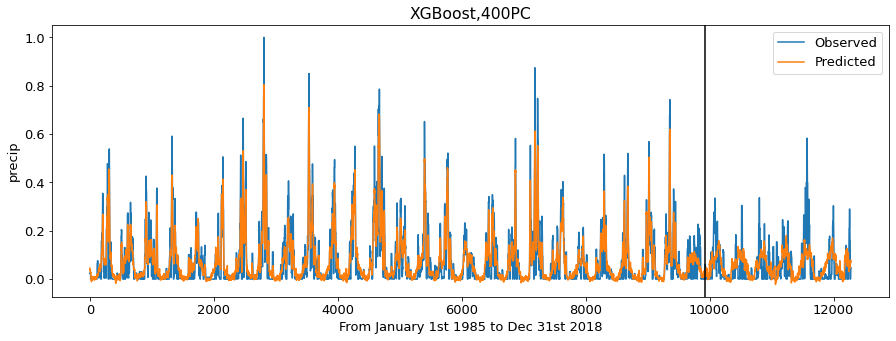

In [72]:
print('r-sq on train:', r2_score(train_seq_y, pred_train))
print('r-sq on test:', r2_score(test_seq_y[train_window+pred_window:],  pred_test[train_window+pred_window:]))
print('cosine_similarity on train:', cosine_similarity(train_seq_y.reshape((1,-1)), pred_train.reshape((1,-1))))
print('cosine_similarity on test:', cosine_similarity(test_seq_y.reshape((1,-1)),  pred_test.reshape((1,-1))))
plt.figure(figsize=(15,5))
plt.plot(np.concatenate((train_seq_y, test_seq_y)),label='Observed')
plt.plot(np.concatenate((pred_train, pred_test)),label='Predicted')
plt.legend()
plt.xlabel('From January 1st 1985 to Dec 31st 2018')
plt.ylabel(target)
plt.title('XGBoost,400PC')
plt.axvline(x=X.shape[0]- test_size,c='black');

r-sq on train: 0.6700248589789446
r-sq on test: -0.13436762987770257
cosine_similarity on train: [[0.88127898]]
cosine_similarity on test: [[0.69298603]]


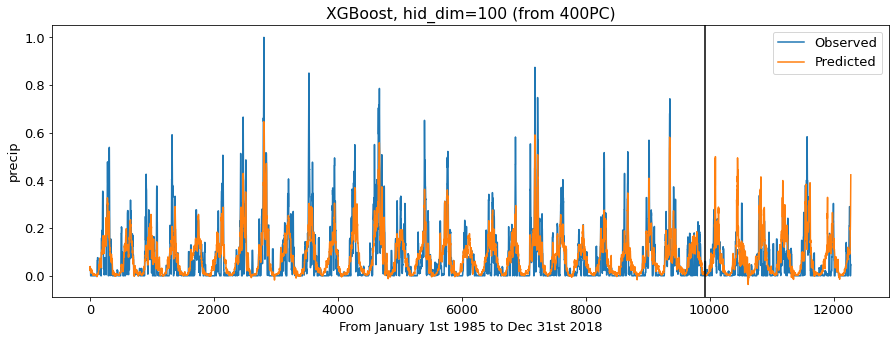

In [99]:
print('r-sq on train:', r2_score(train_seq_y, pred_train))
print('r-sq on test:', r2_score(test_seq_y[train_window+pred_window:],  pred_test[train_window+pred_window:]))
print('cosine_similarity on train:', cosine_similarity(train_seq_y.reshape((1,-1)), pred_train.reshape((1,-1))))
print('cosine_similarity on test:', cosine_similarity(test_seq_y.reshape((1,-1)),  pred_test.reshape((1,-1))))
plt.figure(figsize=(15,5))
plt.plot(np.concatenate((train_seq_y, test_seq_y)),label='Observed')
plt.plot(np.concatenate((pred_train, pred_test)),label='Predicted')
plt.legend()
plt.xlabel('From January 1st 1985 to Dec 31st 2018')
plt.ylabel(target)
plt.title('XGBoost, hid_dim=100 (from 400PC)')
plt.axvline(x=X.shape[0]- test_size,c='black');

r-sq on train: 0.6326623417725008
r-sq on test: -0.10113995047022595
cosine_similarity on train: [[0.8673914]]
cosine_similarity on test: [[0.66103644]]


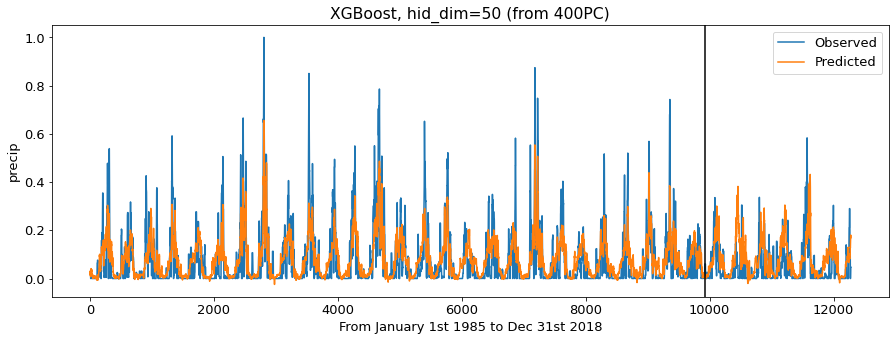

In [96]:
print('r-sq on train:', r2_score(train_seq_y, pred_train))
print('r-sq on test:', r2_score(test_seq_y[train_window+pred_window:],  pred_test[train_window+pred_window:]))
print('cosine_similarity on train:', cosine_similarity(train_seq_y.reshape((1,-1)), pred_train.reshape((1,-1))))
print('cosine_similarity on test:', cosine_similarity(test_seq_y.reshape((1,-1)),  pred_test.reshape((1,-1))))
plt.figure(figsize=(15,5))
plt.plot(np.concatenate((train_seq_y, test_seq_y)),label='Observed')
plt.plot(np.concatenate((pred_train, pred_test)),label='Predicted')
plt.legend()
plt.xlabel('From January 1st 1985 to Dec 31st 2018')
plt.ylabel(target)
plt.title('XGBoost, hid_dim=50 (from 400PC)')
plt.axvline(x=X.shape[0]- test_size,c='black');

r-sq on train: 0.6846533162513294
r-sq on test: 0.014421610228519288
cosine_similarity on train: [[0.88736108]]
cosine_similarity on test: [[0.67590052]]


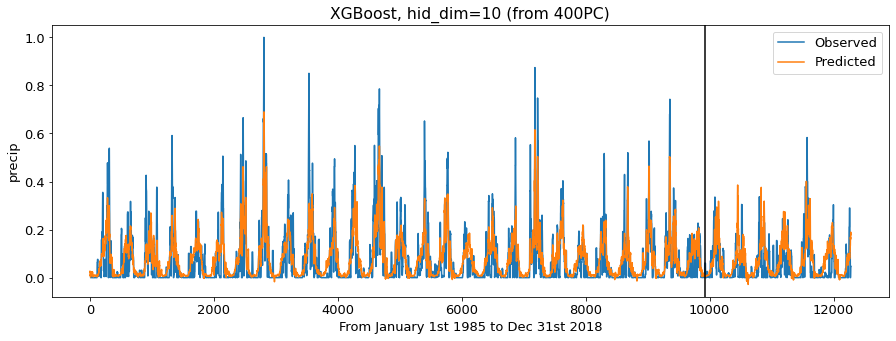

In [134]:
print('r-sq on train:', r2_score(train_seq_y, pred_train))
print('r-sq on test:', r2_score(test_seq_y[train_window+pred_window:],  pred_test[train_window+pred_window:]))
print('cosine_similarity on train:', cosine_similarity(train_seq_y.reshape((1,-1)), pred_train.reshape((1,-1))))
print('cosine_similarity on test:', cosine_similarity(test_seq_y.reshape((1,-1)),  pred_test.reshape((1,-1))))
plt.figure(figsize=(15,5))
plt.plot(np.concatenate((train_seq_y, test_seq_y)),label='Observed')
plt.plot(np.concatenate((pred_train, pred_test)),label='Predicted')
plt.legend()
plt.xlabel('From January 1st 1985 to Dec 31st 2018')
plt.ylabel(target)
plt.title('XGBoost, hid_dim=10 (from 400PC)')
plt.axvline(x=X.shape[0]- test_size,c='black');

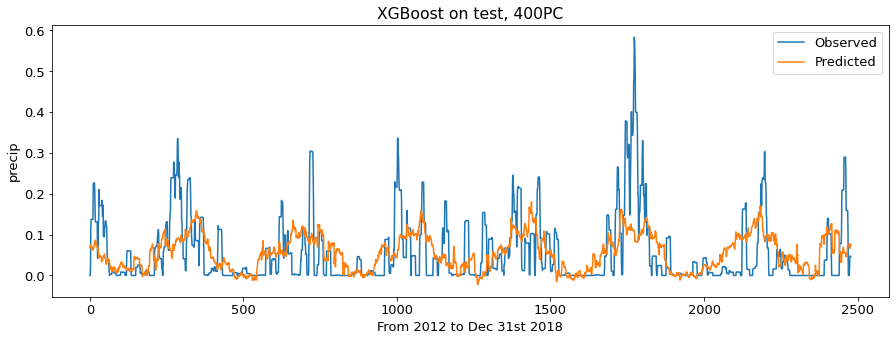

In [73]:
plt.figure(figsize=(15,5))
plt.plot(test_seq_y,label='Observed')
plt.plot(pred_test, label='Predicted')
plt.legend()
plt.xlabel('From 2012 to Dec 31st 2018')
plt.ylabel(target)
plt.title('XGBoost on test, 400PC');

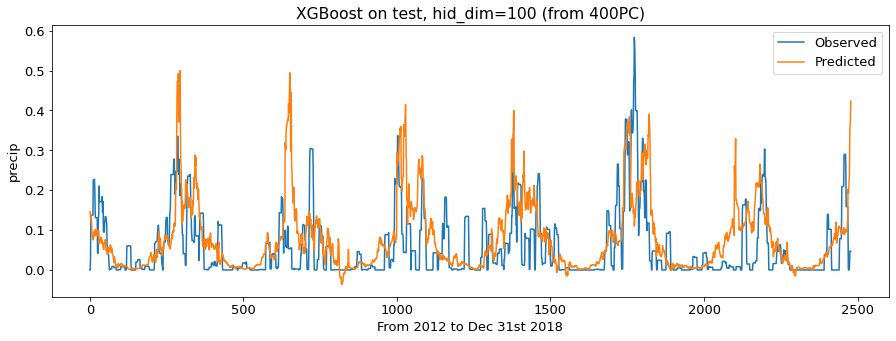

In [100]:
plt.figure(figsize=(15,5))
plt.plot(test_seq_y,label='Observed')
plt.plot(pred_test, label='Predicted')
plt.legend()
plt.xlabel('From 2012 to Dec 31st 2018')
plt.ylabel(target)
plt.title('XGBoost on test, hid_dim=100 (from 400PC)');

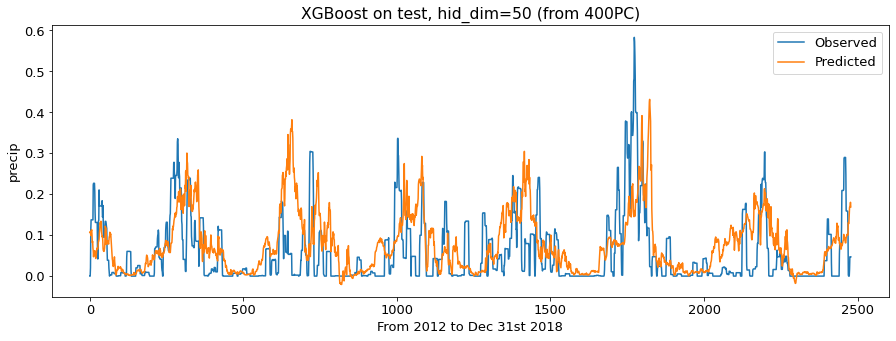

In [97]:
plt.figure(figsize=(15,5))
plt.plot(test_seq_y,label='Observed')
plt.plot(pred_test, label='Predicted')
plt.legend()
plt.xlabel('From 2012 to Dec 31st 2018')
plt.ylabel(target)
plt.title('XGBoost on test, hid_dim=50 (from 400PC)');

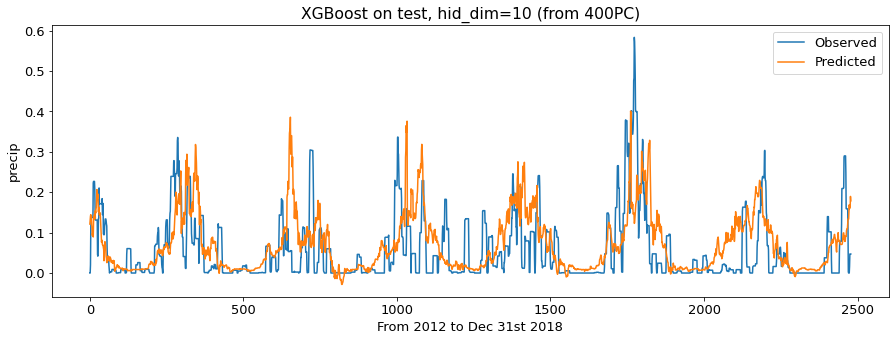

In [135]:
plt.figure(figsize=(15,5))
plt.plot(test_seq_y,label='Observed')
plt.plot(pred_test, label='Predicted')
plt.legend()
plt.xlabel('From 2012 to Dec 31st 2018')
plt.ylabel(target)
plt.title('XGBoost on test, hid_dim=10 (from 400PC)');

In [112]:
test_seq_y.shape, pred_test.shape

((2361,), (2361, 1))

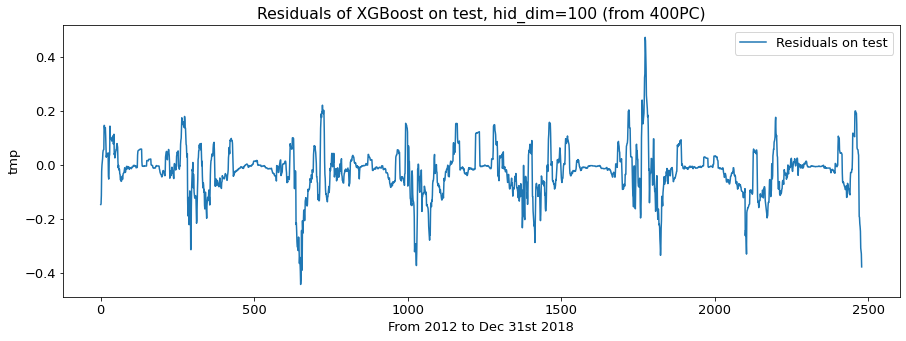

In [101]:
plt.figure(figsize=(15,5))
plt.plot(test_seq_y - pred_test.squeeze(),label='Residuals on test')
plt.legend()
plt.xlabel('From 2012 to Dec 31st 2018')
plt.ylabel('tmp')
plt.title('Residuals of XGBoost on test, hid_dim=100 (from 400PC)');

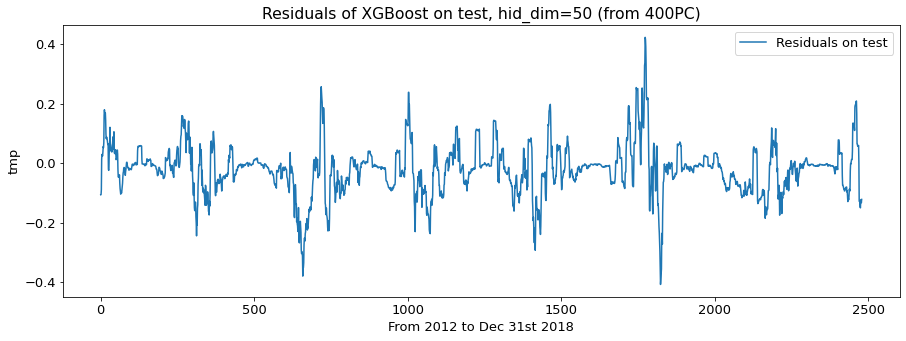

In [98]:
plt.figure(figsize=(15,5))
plt.plot(test_seq_y - pred_test.squeeze(),label='Residuals on test')
plt.legend()
plt.xlabel('From 2012 to Dec 31st 2018')
plt.ylabel('tmp')
plt.title('Residuals of XGBoost on test, hid_dim=50 (from 400PC)');

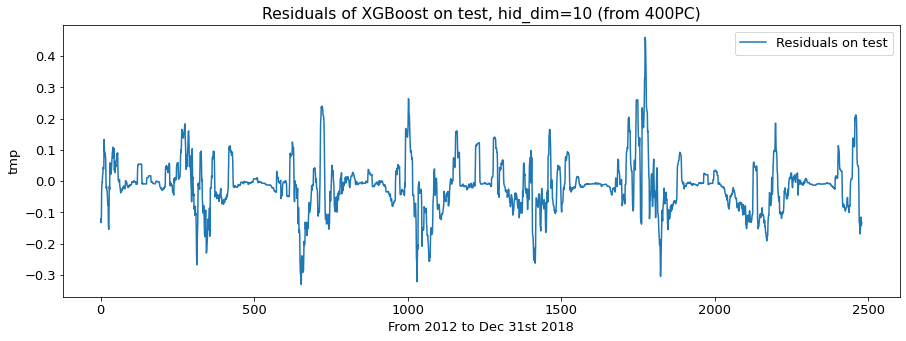

In [136]:
plt.figure(figsize=(15,5))
plt.plot(test_seq_y - pred_test.squeeze(),label='Residuals on test')
plt.legend()
plt.xlabel('From 2012 to Dec 31st 2018')
plt.ylabel('tmp')
plt.title('Residuals of XGBoost on test, hid_dim=10 (from 400PC)');

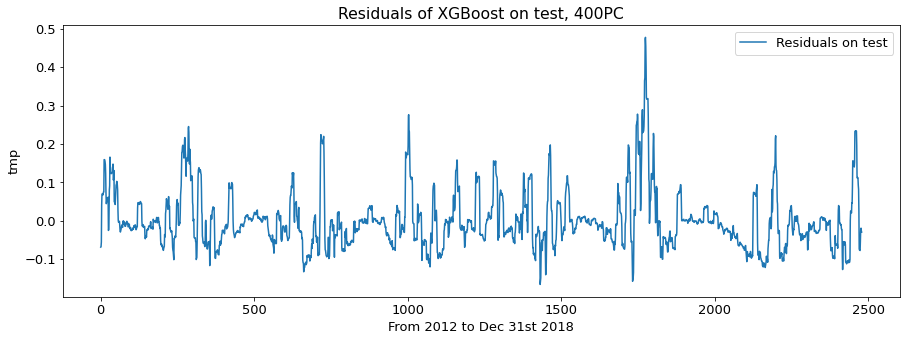

In [75]:
plt.figure(figsize=(15,5))
plt.plot(test_seq_y - pred_test.squeeze(),label='Residuals on test')
plt.legend()
plt.xlabel('From 2012 to Dec 31st 2018')
plt.ylabel('tmp')
plt.title('Residuals of XGBoost on test, 400PC');

### Dim reduction inside of transformer

In [17]:
sst_400_train = np.load('sst_train_400pc_new_smooth.npy')
sst_400_test = np.load('sst_test_400pc_new_smooth.npy')

In [18]:
sst_400_train.shape, sst_400_test.shape

((9917, 400), (2479, 400))

In [19]:
sst_all = np.concatenate((sst_400_train, sst_400_test), axis=0)

In [20]:
sst_all.shape

(12396, 400)

In [21]:
# avg_window = 14
# # y_movavg = []
# X_movavg = []
# for i in range(y_samp.shape[0]-avg_window):
# #     y_avg = np.mean(y_samp[i:i+avg_window])
# #     y_movavg.append(y_avg)
#     X_avg = np.mean(sst_all[i:i+avg_window],axis=0)
#     X_movavg.append(X_avg)

# X_movavg = np.array(X_movavg)
# sst_samp = X_movavg

In [22]:
# sst_samp.shape

In [23]:
train_test_split_sst = 0.8
test_size_sst = int((1-train_test_split)*sst_all.shape[0])
X_train_sst = sst_all[:-test_size]
X_test_sst = sst_all[-test_size:]

In [24]:
X_train_sst.shape, X_test_sst.shape

((9917, 400), (2479, 400))

In [25]:
M = np.max(X_train_sst)
m = np.min(X_test_sst)
X_train_sst = (X_train_sst -m)/(M - m)

X_test_sst = (X_test_sst -m)/(M - m)

train_data_sst = torch.FloatTensor(X_train_sst)

In [26]:
np.max(X_train_sst), np.min(X_test_sst)

(1.0, 0.0)

In [27]:
train_data_sst.shape

torch.Size([9917, 400])

In [28]:
X_train.shape, y_train.shape

((9917, 3), (9917, 1))

In [33]:
train_window = 90
pred_window = 28
train_seq_sst = create_sequence(torch.FloatTensor(train_data_sst), train_window, pred_window)

feature_size 400
train_seq, train_label torch.Size([90, 400]) torch.Size([])


In [34]:
train_data_array = np.concatenate((X_train, y_train), axis=1)
test_data_array = np.concatenate((X_test, y_test), axis=1)
train_data = torch.FloatTensor(train_data_array)
y_train = torch.FloatTensor(y_train)

In [35]:
train_window = 90
pred_window = 28
train_seq = create_sequence(train_data, train_window, pred_window)

feature_size 4
train_seq, train_label torch.Size([90, 4]) torch.Size([])


In [36]:
from torch.utils.data import Dataset, DataLoader

class SeqDataset_sst(Dataset):
    def __init__(self, seq_data, seq_data_sst, transform=None):
        
        self.seq_data = seq_data
        self.seq_data_sst = seq_data_sst
        self.x = []
        self.y = []
        self.sst = []
        print(len(self.seq_data), len(self.seq_data_sst))
        for i in range(len(self.seq_data)):
            self.x.append(self.seq_data[i][0])
            self.y.append(self.seq_data[i][1])
            self.sst.append(self.seq_data_sst[i][0])

    def __getitem__(self, idx):
        if torch.is_tensor(idx):
            idx = idx.tolist()

        return (self.x[idx], self.y[idx], self.sst[idx])

    def __len__(self):
        return len(train_seq) #self._x.shape[0]

In [37]:
dataset_train = SeqDataset_sst(train_seq, train_seq_sst)
dataloader_train = DataLoader(dataset_train,
                              batch_size=128,
                              shuffle=False,
                              num_workers=0,
                              pin_memory=False
                             )

9799 9799


In [38]:
for x, t, st in dataloader_train:
    break

In [39]:
x.shape, t.shape, st.shape

(torch.Size([128, 90, 4]), torch.Size([128]), torch.Size([128, 90, 400]))

In [40]:
len(st), st[1].shape

(128, torch.Size([90, 400]))

In [4]:
d_input = 104 # From dataset
d_output = 1 # From dataset

attention_size = 8
LR = 1e-4 #1e-3
d_model = 64
q = 8 # Query size
v = 8 # Value size
h = 8 # Number of heads
N = 4 # Number of encoder and decoder to stack
dropout = 0.2 # Dropout rate
# pe = 'original' # Positional encoding
chunk_mode = None
net = Transformer_with_sst(d_input, d_model, d_output, q, v, h, N, attention_size=attention_size, 
                  dropout=dropout, chunk_mode=chunk_mode, pe='regular', pe_period=2, seq_length=90, sst_dim=400,
                  hid_dim=10).to(device)
# net = nn.Sequential(Transformer(d_input, d_model, d_output, q, v, h, N, attention_size=attention_size, 
#                   dropout=dropout, chunk_mode=chunk_mode, pe=pe),
#                     nn.Flatten(),
#                     nn.Linear(30, 1),
#                    ).to(device)
optimizer = optim.Adam(net.parameters(), lr=LR)
loss_function = nn.MSELoss() #OZELoss(alpha=0.3)

NameError: name 'device' is not defined

In [5]:
# net.dim_red.train(False);

[Epoch  50/50]: 100%|██████████| 9799/9799 [00:10<00:00, 953.02it/s, loss=0.00869] 


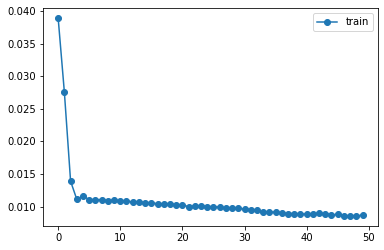

In [44]:
EPOCHS = 50
hist_loss = np.zeros(EPOCHS)
hist_loss_val = np.zeros(EPOCHS)

for idx_epoch in range(EPOCHS):
    if idx_epoch >= 10:
#         for param in net.dim_red.parameters():
#             param.requires_grad = False
        net.dim_red.train(False)
    running_loss = 0
    with tqdm(total=len(train_seq), desc=f"[Epoch {idx_epoch+1:3d}/{EPOCHS}]") as pbar:
        for idx_batch, (x, y_label, sst) in enumerate(dataloader_train):
#             x = x.unsqueeze(0)
            y_label = y_label.view(-1,1)
            sst = sst.to(device)
            optimizer.zero_grad()

            # Propagate input
            netout = net(x.to(device), sst)

            # Compute loss
#             print(netout, y)
            loss = loss_function(y_label.to(device), netout)

            # Backpropage loss
            loss.backward()

            # Update weights
            optimizer.step()

            running_loss += loss.item()
            pbar.set_postfix({'loss': running_loss/(idx_batch+1)})
            pbar.update(x.shape[0])
                
#         scheduler.step()    
        train_loss = running_loss/len(dataloader_train)
#         print('pred, target', netout, y)
#         val_loss = compute_loss(net, dataloader_val, loss_function, device).item()
#         pbar.set_postfix({'loss': train_loss, 'val_loss': val_loss})
        if idx_epoch % 10 ==0 or idx_epoch == EPOCHS-1:
            pbar.set_postfix({'loss': train_loss})

        hist_loss[idx_epoch] = train_loss
#         hist_loss_val[idx_epoch] = val_loss

#         if val_loss < val_loss_best:
#             val_loss_best = val_loss
#             torch.save(net.state_dict(), model_save_path)
        
plt.plot(hist_loss, 'o-', label='train')
# plt.plot(hist_loss_val, 'o-', label='val')
plt.legend()
# print(f"model exported to {model_save_path} with loss {val_loss_best:5f}")

In [45]:
train_test_total = np.concatenate((train_data_array, test_data_array)) 

net.eval()
num_pred = 1 #  Number of prediction forward, i.e. tau
res = np.zeros(train_window).tolist()
#  Predicting y using X_test and y_test
for i in tqdm(range(train_test_total.shape[0]-train_window)):
    for j in range(num_pred):
        seq = torch.FloatTensor(train_test_total[i:i+train_window]).to(device)
        seq = seq.unsqueeze(0)
        sst_seq = torch.FloatTensor(sst_all[i:i+train_window]).to(device)
        sst_seq = sst_seq.unsqueeze(0)
        #print(seq)
        with torch.no_grad():
            #print(model(seq))
            pred = net(seq, sst_seq).cpu()
            #print(len(test_inputs))
            res.append(pred)
            
res = np.array(res)

100%|██████████| 12306/12306 [04:08<00:00, 49.45it/s]


In [46]:
y_all = np.concatenate((y_train.cpu(), y_test))

r-sq on train: 0.25460790416562085
r-sq on test: 0.3250311640901451
cosine_similarity on train: [[0.95128775]]
cosine_similarity on test: [[0.95076056]]


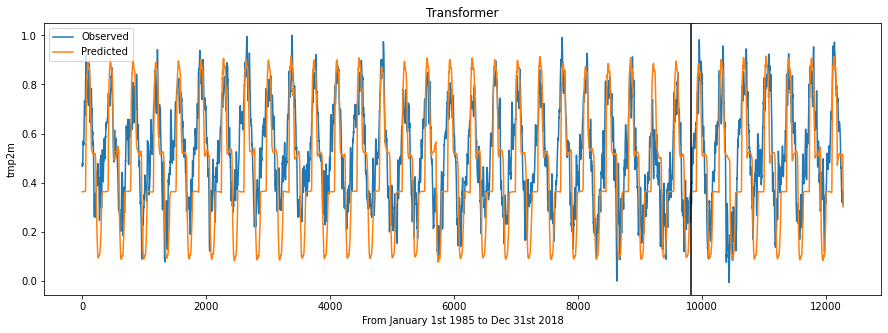

In [47]:
print('r-sq on train:', r2_score(y_all[train_window+pred_window:-test_size], res[train_window:-test_size-pred_window]))
print('r-sq on test:', r2_score(y_all[-test_size:],  res[-test_size-pred_window:-pred_window]))
print('cosine_similarity on train:', cosine_similarity(y_all[train_window+pred_window:-test_size].reshape((1,-1)), res[train_window:-test_size-pred_window].reshape((1,-1))))
print('cosine_similarity on test:', cosine_similarity(y_all[-test_size:].reshape((1,-1)),  res[-test_size-pred_window:-pred_window].reshape((1,-1))))
plt.figure(figsize=(15,5))
plt.plot(y_all[train_window+pred_window:],label='Observed')
plt.plot(res[train_window:-pred_window],label='Predicted')
plt.legend()
plt.xlabel('From January 1st 1985 to Dec 31st 2018')
plt.ylabel(target)
plt.title('Transformer')
plt.axvline(x=res.shape[0] - test_size-train_window,c='black');

r-sq on train: 0.20968412242969703
r-sq on test: 0.17072329170395784
cosine_similarity on train: [[0.94823607]]
cosine_similarity on test: [[0.93749695]]


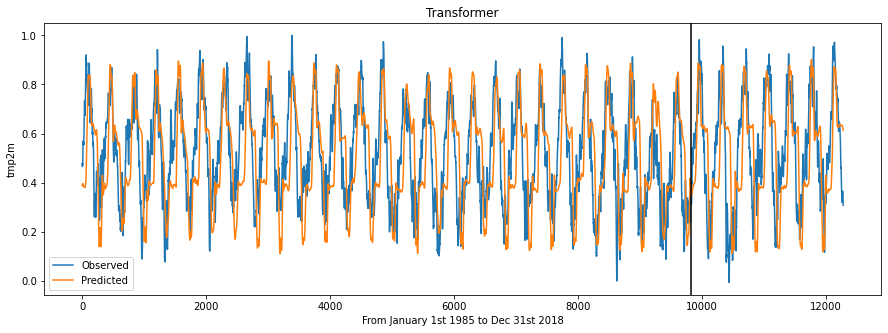

In [48]:
print('r-sq on train:', r2_score(y_all[train_window+pred_window:-test_size], res[train_window:-test_size-pred_window]))
print('r-sq on test:', r2_score(y_all[-test_size:],  res[-test_size-pred_window:-pred_window]))
print('cosine_similarity on train:', cosine_similarity(y_all[train_window+pred_window:-test_size].reshape((1,-1)), res[train_window:-test_size-pred_window].reshape((1,-1))))
print('cosine_similarity on test:', cosine_similarity(y_all[-test_size:].reshape((1,-1)),  res[-test_size-pred_window:-pred_window].reshape((1,-1))))
plt.figure(figsize=(15,5))
plt.plot(y_all[train_window+pred_window:],label='Observed')
plt.plot(res[train_window:-pred_window],label='Predicted')
plt.legend()
plt.xlabel('From January 1st 1985 to Dec 31st 2018')
plt.ylabel(target)
plt.title('Transformer')
plt.axvline(x=res.shape[0] - test_size-train_window,c='black');

r-sq on train: -1.2483135630593871
r-sq on test: -1.0137411659815028
cosine_similarity on train: [[0.84343107]]
cosine_similarity on test: [[0.84155371]]


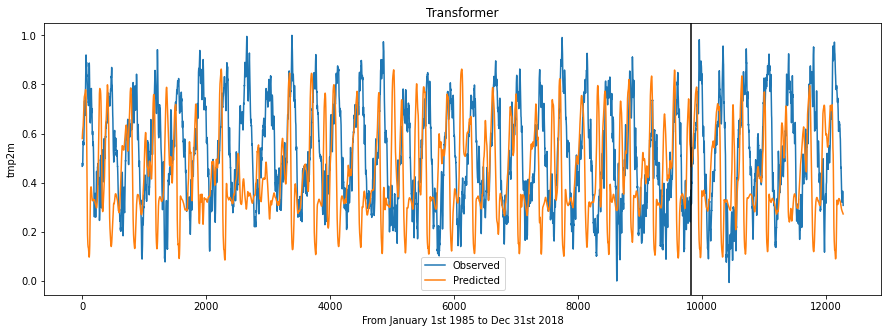

In [44]:
print('r-sq on train:', r2_score(y_all[train_window+pred_window:-test_size], res[train_window:-test_size-pred_window]))
print('r-sq on test:', r2_score(y_all[-test_size:],  res[-test_size-pred_window:-pred_window]))
print('cosine_similarity on train:', cosine_similarity(y_all[train_window+pred_window:-test_size].reshape((1,-1)), res[train_window:-test_size-pred_window].reshape((1,-1))))
print('cosine_similarity on test:', cosine_similarity(y_all[-test_size:].reshape((1,-1)),  res[-test_size-pred_window:-pred_window].reshape((1,-1))))
plt.figure(figsize=(15,5))
plt.plot(y_all[train_window+pred_window:],label='Observed')
plt.plot(res[train_window:-pred_window],label='Predicted')
plt.legend()
plt.xlabel('From January 1st 1985 to Dec 31st 2018')
plt.ylabel(target)
plt.title('Transformer')
plt.axvline(x=res.shape[0] - test_size-train_window,c='black');

r-sq on train: -0.020851769591123448
r-sq on test: -0.04048538449191175
cosine_similarity on train: [[0.93498242]]
cosine_similarity on test: [[0.9255882]]


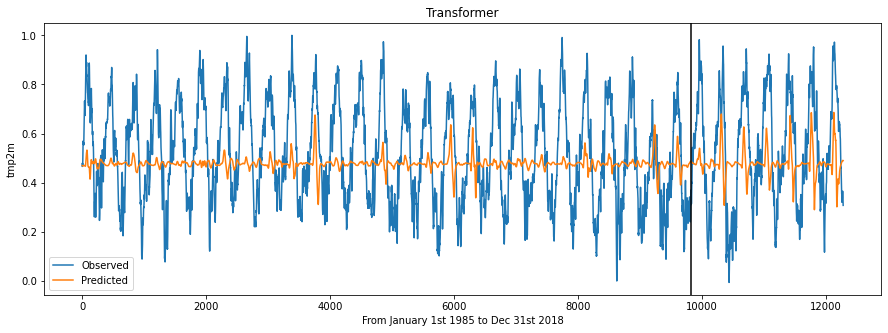

In [226]:
print('r-sq on train:', r2_score(y_all[train_window+pred_window:-test_size], res[train_window:-test_size-pred_window]))
print('r-sq on test:', r2_score(y_all[-test_size:],  res[-test_size-pred_window:-pred_window]))
print('cosine_similarity on train:', cosine_similarity(y_all[train_window+pred_window:-test_size].reshape((1,-1)), res[train_window:-test_size-pred_window].reshape((1,-1))))
print('cosine_similarity on test:', cosine_similarity(y_all[-test_size:].reshape((1,-1)),  res[-test_size-pred_window:-pred_window].reshape((1,-1))))
plt.figure(figsize=(15,5))
plt.plot(y_all[train_window+pred_window:],label='Observed')
plt.plot(res[train_window:-pred_window],label='Predicted')
plt.legend()
plt.xlabel('From January 1st 1985 to Dec 31st 2018')
plt.ylabel(target)
plt.title('Transformer')
plt.axvline(x=res.shape[0] - test_size-train_window,c='black');